# Free end displacement Time history

In [56]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import glob


##################
in_dir = f"/home/jovyan/work/gns_1GPU/rollouts/{dataset}/"
dataset = "Concrete1D"
##################

# Plot
fig, axs = plt.subplots(2, 3, figsize=(40, 20))
fig.suptitle('Time History of Free-end Displacement', fontsize=40, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 24
alpha = 0.7

MAX = np.array([500, 4])
MIN = np.array([-60, -4])
free_end_particle_ids = [1, 2, 3, 4, 5]

def wave_propagation(x, t, v, L):
    ## Analytical solution for 1D concrete wave propagation
    """
    x: free end coordinates, default=0.
    t: time
    v: initial speed
    L: length of beam in meters
    """
    
    E = 1e+7
    rho = 2000
    C = np.sqrt(E/rho)
    res = 0
    for k in range(1, 1000):
        res += 8*(-1)**(k+1)*v*L*np.sin((2*k-1)*C*np.pi*t/2/L)*np.cos((2*k-1)*np.pi*x/2/L)/(np.pi**2*(2*k-1)**2*C)

    return res
    
rollouts = glob.glob(in_dir + '*.pkl')
displacements = {}
for idx, rollout in enumerate(rollouts):
    case = rollout.split('/')[-1]
    if '0' in case:
        L, V = 0.3, 2
        ylim = [-10, 10]
        prefix = 'a'
    elif '1' in case:
        L, V = 0.4, 4
        ylim = [-30, 30]
        prefix = 'b'
    elif '2' in case:
        L, V = 0.5, 8
        ylim = [-60, 60]
        prefix = 'c'
    else:
        print('Rollout unknown!')

    displacement_gt = []
    for t in np.linspace(0, 0.03, 101):
        displacement_gt.append(wave_propagation(0, t, V, L)*1000)

    ## Read data
    with open(rollout, "rb") as file:
        rollout_data = pickle.load(file)

    mid_node = {}
    for ax_i, (label, rollout_field) in enumerate(
        [("LS-DYNA", "ground_truth_rollout"),
        ("GNN", "predicted_rollout")]):
        # Append the initial positions to get the full trajectory.
        trajectory = np.concatenate([
            rollout_data["initial_positions"],
            rollout_data[rollout_field]], axis=0)

        trajectory = trajectory * (MAX - MIN) + MIN ## inverse normalisation 
        mid_node[label] = np.mean(trajectory[:, free_end_particle_ids,:], axis=1)  # average of 5 particles on the free-end

    displacement_gt = np.array(displacement_gt)
    displacement_lsdyna = mid_node['LS-DYNA'][:, 0] - mid_node['LS-DYNA'][0, 0]
    displacement_gnn = mid_node['GNN'][:, 0] - mid_node['GNN'][0, 0]

    axs[0, idx].plot(np.linspace(0,30,101), displacement_gt, 'r-', alpha=alpha)
    axs[0, idx].plot(np.linspace(0,30,101), displacement_lsdyna, 'g-.', alpha=alpha)
    axs[0, idx].plot(np.linspace(0,30,101), displacement_gnn, 'b--', alpha=alpha)
    
    
    axs[0, idx].set_title(f'({prefix}) L={L}m, V$_0$={V}m/s', pad=10)
    axs[0, idx].set_xlabel('Time (ms)')
    axs[0, idx].set_ylabel('Displacement (mm)')
    axs[0, idx].legend(['Analytical', 'SPH', 'GNN'], loc='lower left')
    axs[0, idx].grid(True, linestyle='--')
    axs[0, idx].set_xlim([0, 30])
    axs[0, idx].set_ylim(ylim)
    # Draw boundary
    for axis in ['top','bottom','left','right']:
        axs[0, idx].spines[axis].set_linewidth(3)

    e_gt_dyna = abs((displacement_gt - displacement_lsdyna)) / (abs(displacement_gt) + 1e-8)
    e_gt_gnn = abs((displacement_gt - displacement_gnn)) / (abs(displacement_gt) + 1e-8)
    e_dyna_gnn = abs((displacement_lsdyna - displacement_gnn)) / (abs(displacement_gt) + 1e-8)

    ## Smooth error when gt = 0
    idxs = np.abs(displacement_gt).argsort()[:5]
    for e in [e_gt_dyna, e_gt_gnn, e_dyna_gnn]:
        for ind in idxs:
            e[ind] = e[ind-3]/6 + e[ind-2]/6 + e[ind-1]/6 + e[ind+1]/6 + e[ind+2]/6 + e[ind+3]/6
        e[0] = 0

    axs[1, idx].plot(np.linspace(0,30,51), e_gt_dyna[::2] * 100, 'r-..', alpha=alpha, markersize=10)
    axs[1, idx].plot(np.linspace(0,30,51), e_gt_gnn[::2] * 100, 'g--^', alpha=alpha, markersize=10)
    axs[1, idx].plot(np.linspace(0,30,51), e_dyna_gnn[::2] * 100, 'b--*', alpha=alpha, markersize=10)
    
    # axs[1, idx].set_title('Error-Time')
    axs[1, idx].set_xlabel('Time (ms)')
    axs[1, idx].set_ylabel('Percentage error (%)')
    axs[1, idx].legend([r'SPH $vs.$ Analytical', r'GNN $vs.$ Analytical', r'GNN $vs.$ SPH'])
    axs[1, idx].grid(True, linestyle='--')
    # axs[1, idx].set_xlim([0, 30])
    # axs[1, idx].set_ylim([-0.2, ylim[1]/10])
    # axs[1, idx].annotate(f'L={L}m, V$_0$={V}m/s', xy=(0, 1), xycoords='axes fraction', xytext=(0.1, 0.9), textcoords='axes fraction', fontsize=30)
    # Draw boundary
    for axis in ['top','bottom','left','right']:
        axs[1, idx].spines[axis].set_linewidth(3)

    # plt.savefig(f'Concrete1D_{case}.png', pad_inches=0, dpi=300, bbox_inches='tight')
    
    ## Smooth error when gt = 0
    re_gt_dyna = np.abs((displacement_gt - displacement_lsdyna) / (displacement_gt+1e-8))
    re_gt_gnn = np.abs((displacement_gt - displacement_gnn) / (displacement_gt+1e-8))
    re_dyna_gnn = np.abs((displacement_lsdyna - displacement_gnn)  / (displacement_lsdyna+1e-8))
    
    idxs = np.abs(displacement_gt).argsort()[-20:]
    print(case)
    print('GT-SPH', re_gt_dyna[idxs].mean())
    print('GT-GNN', re_gt_gnn[idxs].mean())
    print('SPH-GNN', re_dyna_gnn[idxs].mean())

NameError: name 'dataset' is not defined

# Runtime analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Runtime_lsdyna = {
                  #500: [6, 5, 7, 5],
                  #750: [8, 7, 6, 7],
                  1000: [9, 10, 8, 7],
                  1250: [8, 9, 11, 10],
                  4328: [27, 26, 28, 28, 27, 27, 27, 28, 60, 29, 26, 25, 25, 28, 30, 63, 31, 30, 26, 29, 27, 30, 26, 57, 26, 67, 26, 26, 25, 26, 59, 25, 29, 25, 30, 26],
                  6356: [35, 97, 37, 65, 34, 36, 77, 58, 45, 43, 40, 35, 53, 38, 85, 40, 54, 40, 34, 37, 36, 49, 74, 71, 37, 78, 39, 71, 36, 35, 33, 38, 56, 39, 39, 40],
                  8404: [52, 48, 74, 48, 52, 92, 96, 48, 48, 98, 61, 51, 47, 53, 47, 45, 47, 51, 69, 48, 79, 46, 49, 45, 48, 48, 88, 47, 49, 85, 58, 48, 47, 62, 52, 66],
                  50000: [200, 210, 225, 198, 220],
                  100000: [380, 390, 400, 395, 386]
                 }

Runtime_gnn = {
               #500: [1.06, 0.96, 0.96, 0.93, 1.00],
               #750: [0.98, 1.11, 1, 1.05, 0.99, 1.06],
               1000: [1.03, 1.07, 1, 1.03, 1.10, 1.12, 1.06],
               1250: [1.14, 1.07, 1.32, 1.08, 1.19, 1.12],
               4328: [3.50, 3.57, 3.49, 3.45, 3.48, 3.42],
               6356: [5.11, 5.04, 5.02, 5.05, 5.15, 5.08],
               8404: [6.56, 6.43, 6.69, 6.64, 6.54, 6.59],
               16448: [13.03, 13.01, 13.12, 12.94],
               24640: [19.51, 19.26, 19.77],
               32800: [25.79, 25.94, 26.04, 26.10, 26.07],
               49184: [39.51, 39.41],
               65504: [53.33, 53.50, 53.53],
               98272: [82.21, 81.90],
               # 131040: [110.25, 111.71, 111.61]
              }

x_lsdyna, x_gnn = [], []
y_lsdyna = []
y_gnn = []
y_lsdyna_err = []
y_gnn_err = []

for key in Runtime_lsdyna:
    x_lsdyna.append(key)
    time_lsdyna = np.array(Runtime_lsdyna[key])
    y_lsdyna.append(time_lsdyna.mean())
    y_lsdyna_err.append(time_lsdyna.std())
    print(f"SPH: {key}, {time_lsdyna.mean()}")
    
for key in Runtime_gnn:
    x_gnn.append(key)
    time_gnn = np.array(Runtime_gnn[key])*0.66
    y_gnn.append(time_gnn.mean())
    y_gnn_err.append(time_gnn.std())
    print(f"GNN: {key}, {time_gnn.mean()}")
    
fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)
fig.suptitle('Runtime Comparison', fontsize=30, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['lines.markersize'] = 12

# ax.errorbar(x_lsdyna, y_lsdyna, yerr=y_lsdyna_err, marker='s', elinewidth=3, capsize=5, color='b', alpha=0.7)
# ax.errorbar(x_gnn, y_gnn, yerr=y_gnn_err, marker='^', elinewidth=3, capsize=5, color='r', alpha=0.7)

y_lsdyna = np.array(y_lsdyna)
y_lsdyna_err = np.array(y_lsdyna_err)
y_gnn = np.array(y_gnn)
y_gnn_err = np.array(y_gnn_err)

ax.plot(x_lsdyna, y_lsdyna, 'b-^', alpha=0.7, label='SPH')
ax.fill_between(x_lsdyna, y_lsdyna-y_lsdyna_err, y_lsdyna+y_lsdyna_err, color='b', alpha=0.1, label='_nolegend_')

ax.plot(x_gnn, y_gnn, 'r-*', alpha=0.7, label='GNN')
ax.fill_between(x_gnn, y_gnn-y_gnn_err, y_gnn+y_gnn_err, color='r', alpha=0.1, label='_nolegend_')

ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of particles')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(['SPH', 'GNN'], prop={'size': 30})
ax.grid(True, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# MAPE-TIME for coordinate, EPS, and MPS

In [ ]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
MAX = np.array([500, 4])
MIN = np.array([-60, -4])
strain_min = 0
strain_max = 2

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 35
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['lines.markersize'] = 10

fig, ax = plt.subplots(1, 3, figsize=(40, 11), constrained_layout=True)
fig.suptitle('Time History of MAPE', fontsize=40, fontweight='bold')


fig2, ax2 = plt.subplots(1, 3, figsize=(40, 11), constrained_layout=True)
fig2.suptitle('Time History of MAPE', fontsize=40, fontweight='bold')

datasets = ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps']

all_losses = {'pos': {}, 'eps': {}, 'mps': {}, 'pos_std': {}, 'eps_std': {}, 'mps_std': {}}
for dataset in datasets:
    in_dir = f'/home/jovyan/work/gns_1GPU/rollouts/{dataset}/'
    
    rollouts = glob.glob(in_dir + '*.pkl')       
        
    losses_timestep_pos = np.array([]).reshape(101, 0)
    losses_timestep_pos_std = np.array([]).reshape(101, 0)
    losses_timestep_strain = np.array([]).reshape(101, 0)
    losses_timestep_strain_std = np.array([]).reshape(101, 0)
    
    for rollout in rollouts:
        with open(rollout, "rb") as file:
            rollout_data = pickle.load(file)

        if 'Concrete2D-C' in dataset:
            MAX, MIN = MAX_C, MIN_C
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete2D-I' in dataset:
            MAX, MIN = MAX_I, MIN_I
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete1D' in dataset:
            y_scaling_factor = 1

        displacement = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_rollout"), ("GNN", "predicted_rollout")]:

            # Append the initial positions to get the full trajectory.
            trajectory = np.concatenate([
                rollout_data["initial_positions"],
                rollout_data[rollout_field]], axis=0)
            trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
            trajectory = trajectory * (MAX - MIN) + MIN ## qilin 
            displacement[label] = trajectory - trajectory[0, :, :]
        
        # rmse = np.sqrt((pos['LS-DYNA'] - pos['GNN'])**2).mean(axis=(1,2))
        mape = abs((displacement['LS-DYNA'] - displacement['GNN']) / (displacement['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (displacement['LS-DYNA'] < 0.1) , mape)  # masked out those with 100% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=(1,2))
        loss_timestep = mape_masked_mean
       
        losses_timestep_pos = np.concatenate((losses_timestep_pos, loss_timestep.reshape(-1,1)), axis=1)
        
        strains = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_strain"), ("GNN", "predicted_strain")]:

            # Append the initial positions to get the full trajectory.
            strain = rollout_data[rollout_field]
            #strain = strain * (strain_max - strain_min) + strain_min   ## inverse normalisation
            strains[label] = strain
            
        #rmse = np.sqrt((strains['LS-DYNA'] - strains['GNN'])**2).mean(axis=1)
        mape = abs((strains['LS-DYNA'] - strains['GNN']) / (strains['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1), mape)  # masked out those with 500% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=1)
        loss_timestep = mape_masked_mean
        
        losses_timestep_strain = np.concatenate((losses_timestep_strain, loss_timestep.reshape(-1,1)), axis=1)
    
    # Average over rollouts in a dataset
    all_losses['pos'][dataset] = losses_timestep_pos.mean(axis=1)  
    all_losses['pos_std'][dataset] = losses_timestep_pos.std(axis=1)
    
    if 'mps' in dataset:
        all_losses['mps'][dataset] = losses_timestep_strain.mean(axis=1) 
        all_losses['mps_std'][dataset] = losses_timestep_strain.std(axis=1)
    else:
        all_losses['eps'][dataset] = losses_timestep_strain.mean(axis=1)
        all_losses['eps_std'][dataset] = losses_timestep_strain.std(axis=1) 

idx = 0 
y1 = all_losses['pos']['Concrete2D-C']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['pos_std']['Concrete2D-C'][ind-2:]
ax[idx].plot(x1, y1*100, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1)*100, (y1+error1)*100, color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['pos']['Concrete2D-I']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['pos_std']['Concrete2D-I'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(a) Displacement', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    axs[idx].set_xlim([0, 100])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)
    
idx = 1 
y1 = all_losses['eps']['Concrete2D-C']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['eps_std']['Concrete2D-C'][ind-2:]
ax[idx].plot(x1, y1*100, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1)*100, (y1+error1)*100, color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['eps']['Concrete2D-I']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['eps_std']['Concrete2D-I'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(b) EPS', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    axs[idx].set_xlim([0, 100])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)
    
idx = 2 
y1 = all_losses['mps']['Concrete2D-C-mps']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['mps_std']['Concrete2D-C-mps'][ind-2:]
ax[idx].plot(x1, y1*100, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1)*100, (y1+error1)*100, color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['mps']['Concrete2D-I-mps']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['mps_std']['Concrete2D-I-mps'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(c) MPS', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    axs[idx].set_xlim([0, 100])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)

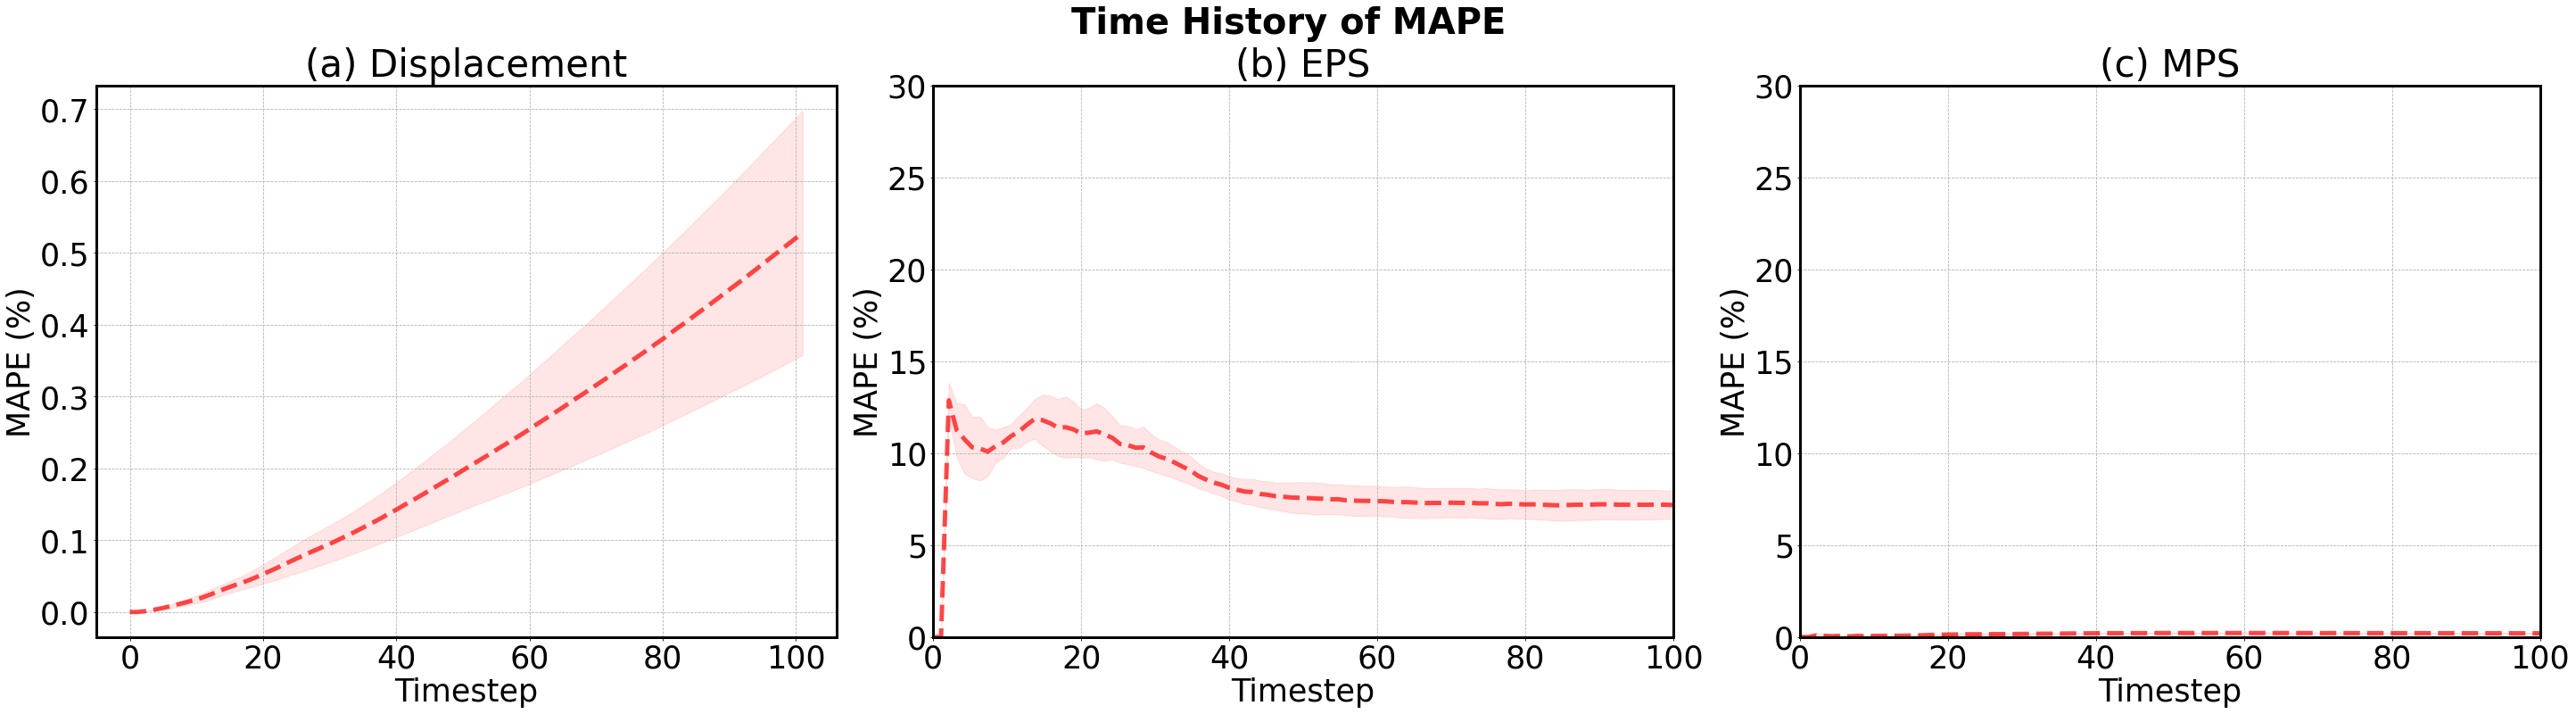

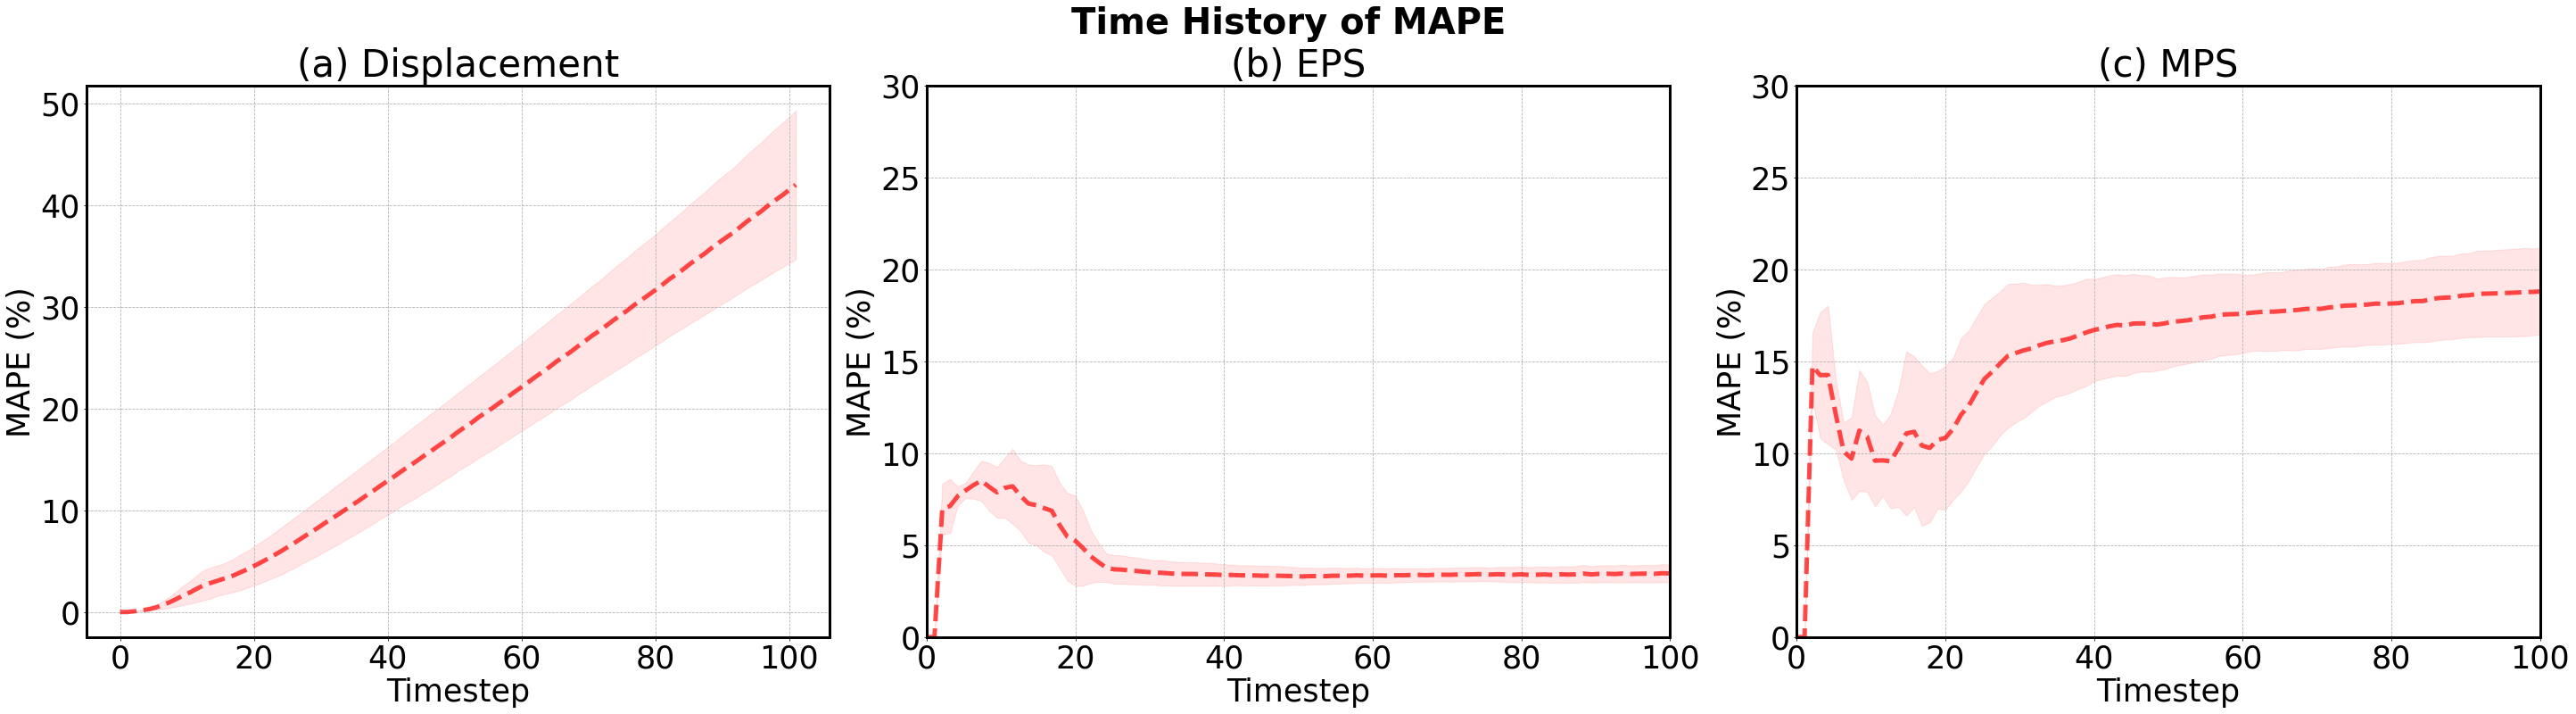

In [67]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
MAX = np.array([500, 4])
MIN = np.array([-60, -4])
strain_min = 0
strain_max = 2

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 35
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['lines.markersize'] = 10

fig, ax = plt.subplots(1, 3, figsize=(40, 11), constrained_layout=True)
fig.suptitle('Time History of MAPE', fontsize=40, fontweight='bold')


fig2, ax2 = plt.subplots(1, 3, figsize=(40, 11), constrained_layout=True)
fig2.suptitle('Time History of MAPE', fontsize=40, fontweight='bold')

datasets = ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps']

all_losses = {'pos': {}, 'eps': {}, 'mps': {}, 'pos_std': {}, 'eps_std': {}, 'mps_std': {}}
for dataset in datasets:
    in_dir = f'/home/jovyan/work/gns_1GPU/rollouts/{dataset}/'
    
    rollouts = glob.glob(in_dir + '*.pkl')       
        
    losses_timestep_pos = np.array([]).reshape(101, 0)
    losses_timestep_pos_std = np.array([]).reshape(101, 0)
    losses_timestep_strain = np.array([]).reshape(101, 0)
    losses_timestep_strain_std = np.array([]).reshape(101, 0)
    
    for rollout in rollouts:
        with open(rollout, "rb") as file:
            rollout_data = pickle.load(file)

        if 'Concrete2D-C' in dataset:
            MAX, MIN = MAX_C, MIN_C
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete2D-I' in dataset:
            MAX, MIN = MAX_I, MIN_I
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete1D' in dataset:
            y_scaling_factor = 1

        displacement = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_rollout"), ("GNN", "predicted_rollout")]:

            # Append the initial positions to get the full trajectory.
            trajectory = np.concatenate([
                rollout_data["initial_positions"],
                rollout_data[rollout_field]], axis=0)
            trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
            trajectory = trajectory * (MAX - MIN) + MIN ## qilin 
            displacement[label] = trajectory - trajectory[0, :, :]
        
        # rmse = np.sqrt((pos['LS-DYNA'] - pos['GNN'])**2).mean(axis=(1,2))
        mape = abs((displacement['LS-DYNA'] - displacement['GNN']))
        mape_masked = np.ma.masked_where((mape < 0) | (displacement['LS-DYNA'] < 0) , mape)  # masked out those with 100% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=(1,2))
        loss_timestep = mape_masked_mean
       
        losses_timestep_pos = np.concatenate((losses_timestep_pos, loss_timestep.reshape(-1,1)), axis=1)
        
        strains = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_strain"), ("GNN", "predicted_strain")]:

            # Append the initial positions to get the full trajectory.
            strain = rollout_data[rollout_field]
            #strain = strain * (strain_max - strain_min) + strain_min   ## inverse normalisation
            strains[label] = strain
            
        #rmse = np.sqrt((strains['LS-DYNA'] - strains['GNN'])**2).mean(axis=1)
        mape = abs((strains['LS-DYNA'] - strains['GNN']) / (strains['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1), mape)  # masked out those with 500% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=1)
        loss_timestep = mape_masked_mean
        
        losses_timestep_strain = np.concatenate((losses_timestep_strain, loss_timestep.reshape(-1,1)), axis=1)
    
    # Average over rollouts in a dataset
    all_losses['pos'][dataset] = losses_timestep_pos.mean(axis=1)  
    all_losses['pos_std'][dataset] = losses_timestep_pos.std(axis=1)
    
    if 'mps' in dataset:
        all_losses['mps'][dataset] = losses_timestep_strain.mean(axis=1) 
        all_losses['mps_std'][dataset] = losses_timestep_strain.std(axis=1)
    else:
        all_losses['eps'][dataset] = losses_timestep_strain.mean(axis=1)
        all_losses['eps_std'][dataset] = losses_timestep_strain.std(axis=1) 

idx = 0 
y1 = all_losses['pos']['Concrete2D-C']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['pos_std']['Concrete2D-C'][ind-2:]
ax[idx].plot(x1, y1, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1), (y1+error1), color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['pos']['Concrete2D-I']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['pos_std']['Concrete2D-I'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(a) Displacement', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    # axs[idx].set_xlim([0, 100])
    # axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)
    
idx = 1 
y1 = all_losses['eps']['Concrete2D-C']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['eps_std']['Concrete2D-C'][ind-2:]
ax[idx].plot(x1, y1*100, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1)*100, (y1+error1)*100, color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['eps']['Concrete2D-I']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['eps_std']['Concrete2D-I'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(b) EPS', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    axs[idx].set_xlim([0, 100])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)
    
idx = 2 
y1 = all_losses['mps']['Concrete2D-C-mps']
ind = sum(y1 == 0)
y1 = y1[ind-2:]
x1 = np.linspace(0, 101, y1.shape[0])
error1 = all_losses['mps_std']['Concrete2D-C-mps'][ind-2:]
ax[idx].plot(x1, y1, 'r--', alpha=0.7, label='2D-C')
ax[idx].fill_between(x1, (y1-error1), (y1+error1), color='r', alpha=0.1, label='_nolegend_')

y2 = all_losses['mps']['Concrete2D-I-mps']
ind = sum(y2 == 0)
y2 = y2[ind-2:]
x2 = np.linspace(0, 101, y2.shape[0])
error2 = all_losses['mps_std']['Concrete2D-I-mps'][ind-2:]
ax2[idx].plot(x2, y2*100, 'r--', alpha=0.7, label='2D-I')
ax2[idx].fill_between(x2, (y2-error2)*100, (y2+error2)*100, color='r', alpha=0.1, label='_nolegend_')

for axs in [ax, ax2]:
    axs[idx].set_title(f'(c) MPS', pad=10)
    axs[idx].set_xlabel('Timestep')
    axs[idx].set_ylabel('MAPE (%)')
    axs[idx].set_xlim([0, 100])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(True, linestyle='--')
    for axis in ['top','bottom','left','right']:
        axs[idx].spines[axis].set_linewidth(3)

# Generalisation vs Standard testing

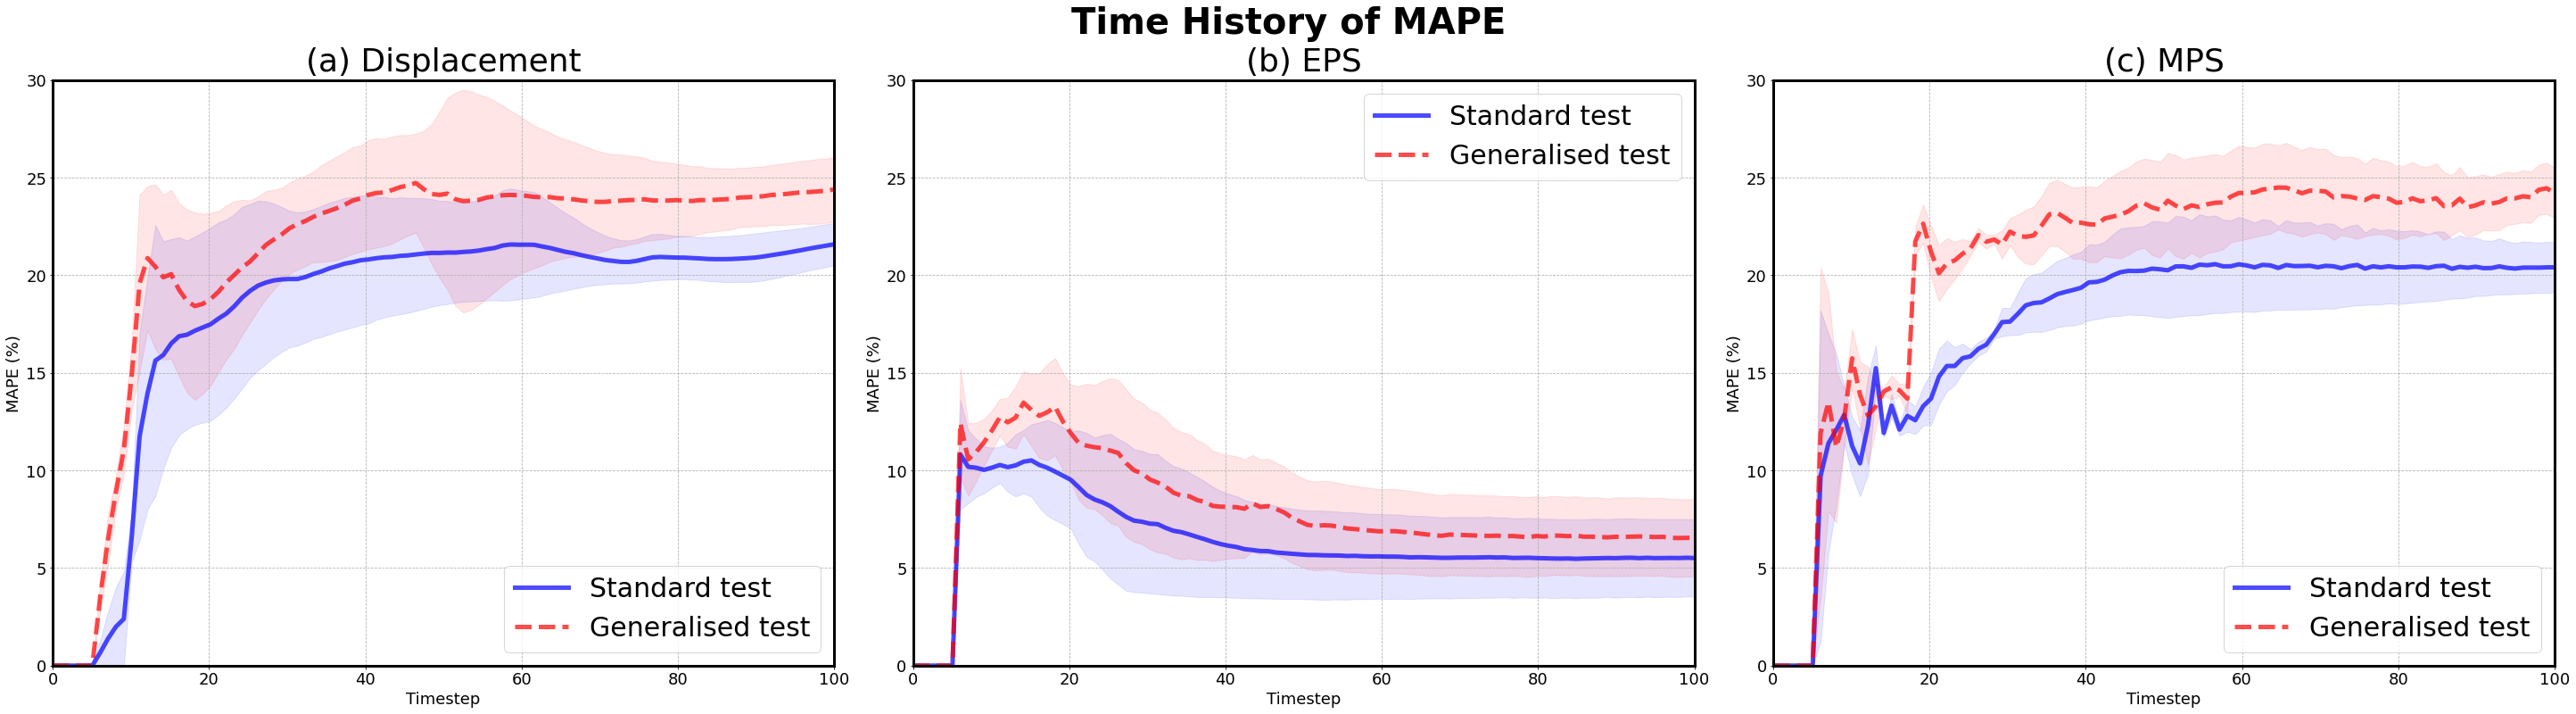

In [59]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
MAX = np.array([500, 4])
MIN = np.array([-60, -4])
strain_min = 0
strain_max = 2

fig, ax = plt.subplots(1, 3, figsize=(40, 11), constrained_layout=True)
fig.suptitle('Time History of MAPE', fontsize=40, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 30
plt.rcParams['lines.markersize'] = 10

# Rollouts = {'Concrete2D-C-generalize': ['C_60_240_V22_extrapolation', 'C_80_560_V14_intrapolation', 'C_60_240_V6_extrapolation'],
#             'Concrete2D-C-mps-generalize': ['C_60_240_V22_extrapolation', 'C_60_240_V6_extrapolation', 'C_80_560_V14_intrapolation'],
#             'Concrete2D-I-generalize': ['S_100_800_V60_extrapolation', 'S_80_400_V140_intrapolation'],
#             'Concrete2D-I-mps-generalize': ['S_80_400_V140_intrapolation', 'S_100_800_V60_extrapolation']
#            }

datasets = ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps',
           'Concrete2D-C-generalize',  'Concrete2D-I-generalize', 'Concrete2D-C-mps-generalize', 'Concrete2D-I-mps-generalize']

all_losses = {'pos': {}, 'eps': {}, 'mps': {}, 'pos_std': {}, 'eps_std': {}, 'mps_std': {}}
for dataset in datasets:
    in_dir = f'/home/jovyan/work/gns_1GPU/rollouts/{dataset}/'
    
    rollouts = glob.glob(in_dir + '*.pkl') 
    # if dataset == 'Concrete2D-I-generalize':
    #     rollouts = [in_dir + f'rollout_{x}.pkl' for x in [1]]
    # elif dataset == 'Concrete2D-I-mps-generalize':
    #     rollouts = [in_dir + f'rollout_{x}.pkl' for x in [0]]

    losses_timestep_pos = np.array([]).reshape(101, 0)
    losses_timestep_pos_std = np.array([]).reshape(101, 0)
    losses_timestep_strain = np.array([]).reshape(101, 0)
    losses_timestep_strain_std = np.array([]).reshape(101, 0)
    
    for rollout in rollouts:
        with open(rollout, "rb") as file:
            rollout_data = pickle.load(file)

        if 'Concrete2D-C' in dataset:
            MAX, MIN = MAX_C, MIN_C
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete2D-I' in dataset:
            MAX, MIN = MAX_I, MIN_I
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete1D' in dataset:
            y_scaling_factor = 1

        displacement = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_rollout"), ("GNN", "predicted_rollout")]:

            # Append the initial positions to get the full trajectory.
            trajectory = np.concatenate([
                rollout_data["initial_positions"],
                rollout_data[rollout_field]], axis=0)
            trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
            trajectory = trajectory * (MAX - MIN) + MIN ## qilin 
            displacement[label] = trajectory - trajectory[0, :, :]
        
        # rmse = np.sqrt((pos['LS-DYNA'] - pos['GNN'])**2).mean(axis=(1,2))
        mape = abs((displacement['LS-DYNA'] - displacement['GNN']) / (displacement['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (displacement['LS-DYNA'] < 0.1) , mape)  # masked out those with 500% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=(1,2))
        loss_timestep = mape_masked_mean
       
        losses_timestep_pos = np.concatenate((losses_timestep_pos, loss_timestep.reshape(-1,1)), axis=1)
        
        strains = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_strain"), ("GNN", "predicted_strain")]:

            # Append the initial positions to get the full trajectory.
            strain = rollout_data[rollout_field]
            strain = strain * (strain_max - strain_min) + strain_min   ## inverse normalisation
            strains[label] = strain
            
        #rmse = np.sqrt((strains['LS-DYNA'] - strains['GNN'])**2).mean(axis=1)
        mape = abs((strains['LS-DYNA'] - strains['GNN']) / (strains['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1), mape)  # masked out those with 500% error due to numerical instability
        mape_masked_mean = mape_masked.mean(axis=1)
        loss_timestep = mape_masked_mean
        
        losses_timestep_strain = np.concatenate((losses_timestep_strain, loss_timestep.reshape(-1,1)), axis=1)
    
    # Average over rollouts in a dataset
    all_losses['pos'][dataset] = losses_timestep_pos.mean(axis=1)  
    all_losses['pos_std'][dataset] = losses_timestep_pos.std(axis=1)
    
    if 'mps' in dataset:
        all_losses['mps'][dataset] = losses_timestep_strain.mean(axis=1) 
        all_losses['mps_std'][dataset] = losses_timestep_strain.std(axis=1)
    else:
        all_losses['eps'][dataset] = losses_timestep_strain.mean(axis=1)
        all_losses['eps_std'][dataset] = losses_timestep_strain.std(axis=1) 
        
# Average over datasets (standard testing)
loss_pos = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps']:
    loss_pos = np.concatenate((loss_pos, all_losses['pos'][dataset].reshape(-1,1)), axis=1)
rmse_pos = loss_pos.mean(axis=1)
rmse_pos_std = loss_pos.std(axis=1)

loss_eps = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C',  'Concrete2D-I']:
    loss_eps = np.concatenate((loss_eps, all_losses['eps'][dataset].reshape(-1,1)), axis=1)
rmse_eps = loss_eps.mean(axis=1)
rmse_eps_std = loss_eps.std(axis=1)

loss_mps = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C-mps',  'Concrete2D-I-mps']:
    loss_mps = np.concatenate((loss_mps, all_losses['mps'][dataset].reshape(-1,1)), axis=1)
rmse_mps = loss_mps.mean(axis=1)
rmse_mps_std = loss_mps.std(axis=1)

# Average over datasets (generalization testing)
loss_pos = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C-generalize',  'Concrete2D-I-generalize', 'Concrete2D-C-mps-generalize', 'Concrete2D-I-mps-generalize']:
    loss_pos = np.concatenate((loss_pos, all_losses['pos'][dataset].reshape(-1,1)), axis=1)
rmse_pos_ge = loss_pos.mean(axis=1)
rmse_pos_std_ge = loss_pos.std(axis=1)

loss_eps = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C-generalize',  'Concrete2D-I-generalize']:
    loss_eps = np.concatenate((loss_eps, all_losses['eps'][dataset].reshape(-1,1)), axis=1)
rmse_eps_ge = loss_eps.mean(axis=1)
rmse_eps_std_ge = loss_eps.std(axis=1)

loss_mps = np.array([]).reshape(101, 0)
for dataset in ['Concrete2D-C-mps-generalize',  'Concrete2D-I-mps-generalize']:
    loss_mps = np.concatenate((loss_mps, all_losses['mps'][dataset].reshape(-1,1)), axis=1)
rmse_mps_ge = loss_mps.mean(axis=1)
rmse_mps_std_ge = loss_mps.std(axis=1)

idx = 0 
ax[idx].set_title(f'(a) Displacement', pad=10)
x = np.linspace(0, 101, 101)
y1 = rmse_pos * 100
error1 = rmse_pos_std * 100
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = rmse_pos_ge * 100
error2 = rmse_pos_std_ge * 100
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I-generalize')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('MAPE (%)')
ax[idx].set_xlim([0, 100])
ax[idx].set_ylim([0, 30])
ax[idx].legend(['Standard test', 'Generalised test'], prop={'size': 30}, loc='lower right')
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3)
    
idx = 1 
ax[idx].set_title(f'(b) EPS', pad=10)
x = np.linspace(0, 101, 101)
y1 = rmse_eps * 100
error1 = rmse_eps_std * 100
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C-generalize')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = rmse_eps_ge * 100
error2 = rmse_eps_std * 100
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I-generalize')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('MAPE (%)')
ax[idx].set_xlim([0, 100])
ax[idx].set_ylim([0, 30])
ax[idx].legend(['Standard test', 'Generalised test'], prop={'size': 30})
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3)
    
idx = 2 
ax[idx].set_title(f'(c) MPS', pad=10)
x = np.linspace(0, 101, 101)
y1 = rmse_mps * 100
error1 = rmse_mps_std * 100
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C-generalize')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = rmse_mps_ge * 100
error2 = rmse_mps_std * 100
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I-generalize')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('MAPE (%)')
ax[idx].set_xlim([0, 100])
ax[idx].set_ylim([0, 30])
ax[idx].legend(['Standard test', 'Generalised test'], prop={'size': 30}, loc='lower right')
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3) 

# Generalisation Time history

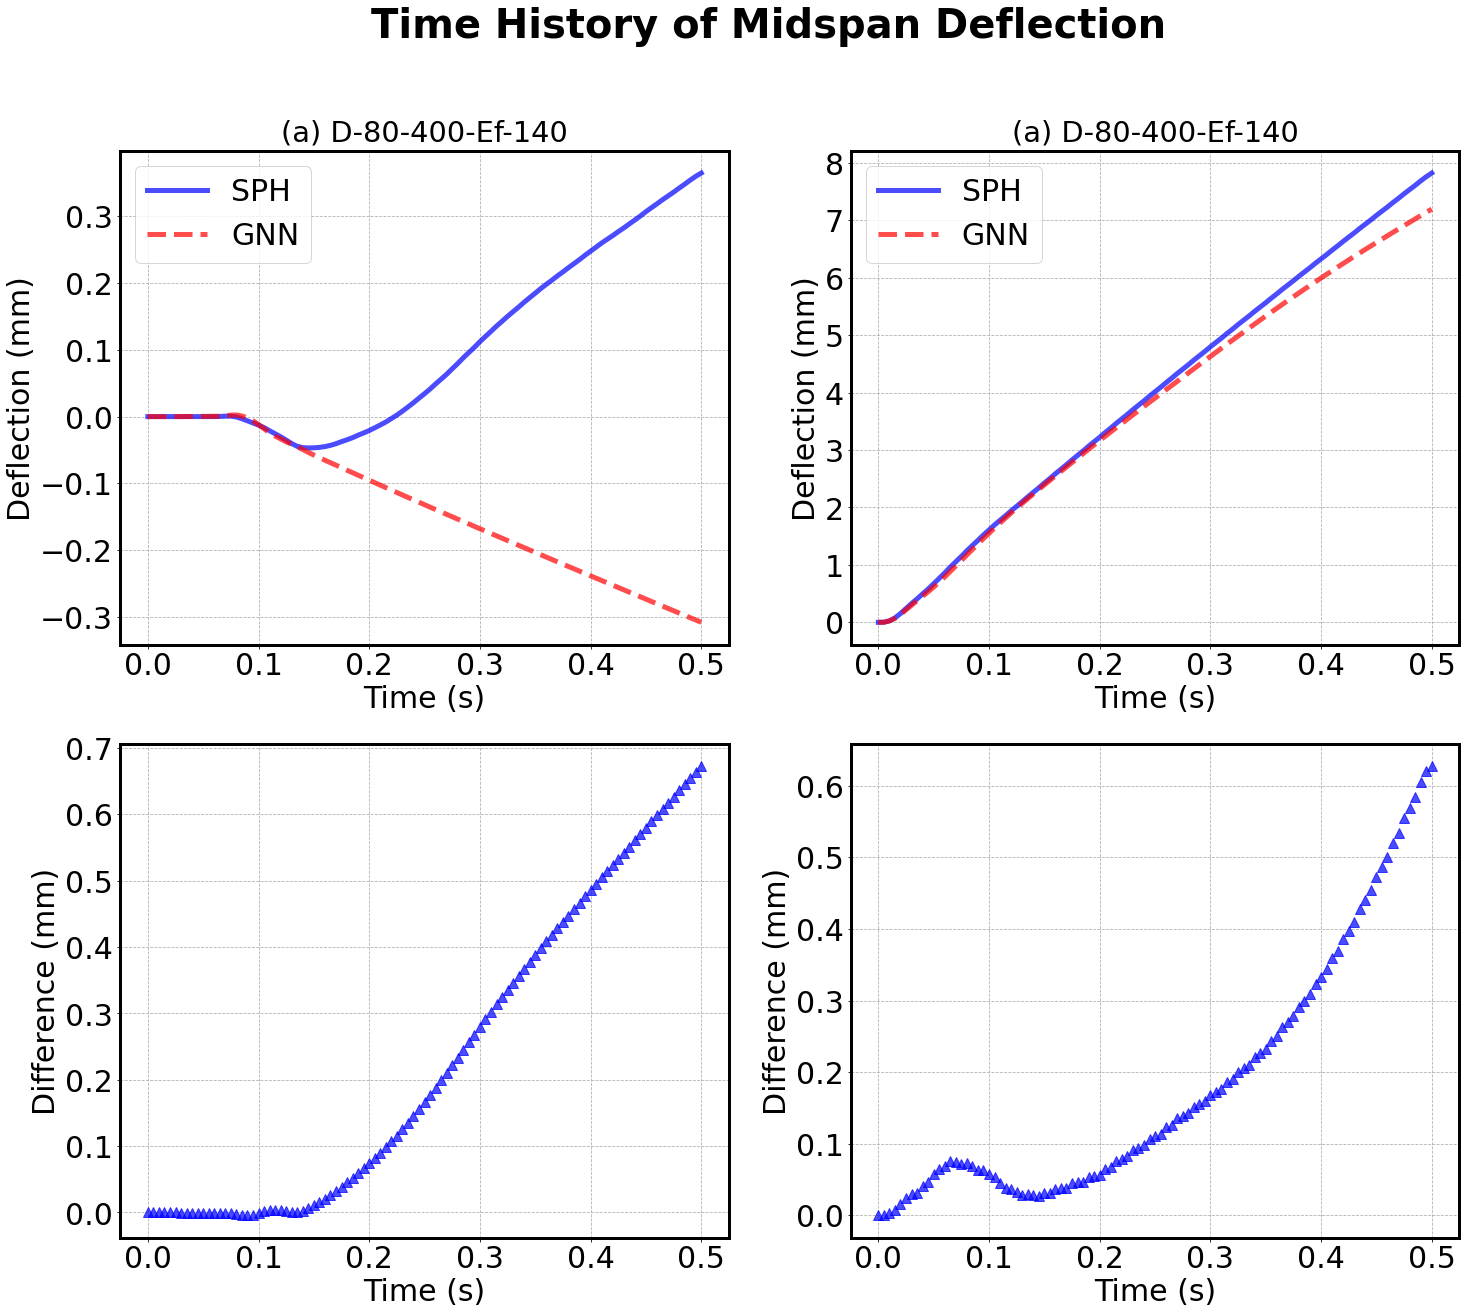

In [60]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#########################
dataset = 'Concrete2D-I-generalize'
#########################

# Fig
alpha = 0.7
fig, axs = plt.subplots(2, 2, figsize=(24, 20), constrained_layout=False)
fig.suptitle('Time History of Midspan Deflection', fontsize=40, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 24
    
MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])

MID_SPAN_ID_320 = [2032, 2033, 2064, 2065] ## for 320
MID_SPAN_ID_480 = [3056, 3057, 3088, 3089] ## for 480
MID_SPAN_ID_640 = [4080, 4081, 4112, 4113] ## for 640

MID_SPAN_ID_240 = [1116, 1117, 1140, 1141, 1164, 1165]
MID_SPAN_ID_400 = [2720, 2721, 2752, 2753, 2784, 2785]
MID_SPAN_ID_560 = [3568, 3569, 3600, 3601, 3632, 3633]
MID_SPAN_ID_800 = [6516, 6517, 6556, 6557, 6596, 6597]

# rollouts 5,1,3 for 2d-I
# rollouts 9,6,1 for 2d-C
for figID, id in enumerate([0, 1]):
    rollout_path = f"/home/jovyan/work/gns_1GPU/rollouts/{dataset}/rollout_{id}.pkl"

    with open(rollout_path, "rb") as file:
        rollout_data = pickle.load(file)

    simulation_name = rollout_data['metadata']['file_test'][id]

    if 'Concrete2D-C' in rollout_path:
        MAX, MIN = MAX_C, MIN_C
    else:
        MAX, MIN = MAX_I, MIN_I
    y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
    
    if '320' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_320
        L = 320
    elif '480' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_480
        L = 480
    elif '640' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_640
        L = 640
    elif '240' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_240
        L = 240
    elif '400' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_400
        L = 400
    elif '560' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_560
        L = 560
    elif '800' in simulation_name:
        MID_SPAN_ID = MID_SPAN_ID_800
        L = 800
    else:
        print('sth wrong with the simulation name!')
        
    V = simulation_name.split('_')[-1]

    mid_node = {}
    for ax_i, (label, rollout_field) in enumerate(
      [("LS-DYNA", "ground_truth_rollout"),
       ("GNN", "predicted_rollout")]):

        trajectory = np.concatenate([
            rollout_data["initial_positions"],
            rollout_data[rollout_field]], axis=0)
        trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
        trajectory = trajectory * (MAX - MIN) + MIN ## inverse normalisation

        mid_node[label] = np.mean(trajectory[:, MID_SPAN_ID,:], axis=1)  # average of 5 particles on the free-end

    deflection_lydyna = mid_node['LS-DYNA'][0, 1] - mid_node['LS-DYNA'][:, 1]
    deflection_gnn = (mid_node['GNN'][0, 1] - mid_node['GNN'][:, 1])*0.9

    # Plot
    num_steps = trajectory.shape[0]

    axs[0,figID].plot(np.linspace(0, 0.5, num_steps), deflection_lydyna, 'b-', alpha=alpha, label='SPH')
    axs[0,figID].plot(np.linspace(0, 0.5, num_steps), deflection_gnn, 'r--', alpha=alpha, label='GNN')
    
    simulation_name = simulation_name.replace('_', '-')
    axs[0,figID].set_title(f'(a) D-80-400-Ef-140',pad=10)
    axs[0,figID].set_xlabel('Time (s)')
    axs[0,figID].set_ylabel('Deflection (mm)')
    axs[0,figID].legend(['SPH', 'GNN'], prop={'size': 30})
    axs[0,figID].grid(True, linestyle='--')
    
    # axs[0].set_xlim([0, 32])
    # axs[0].set_ylim(ylim)
    # Draw boundary
    for axis in ['top','bottom','left','right']:
        axs[0,figID].spines[axis].set_linewidth(3)


    error = ((deflection_lydyna - deflection_gnn) / 1)


    axs[1,figID].plot(np.linspace(0, 0.5, num_steps), error, 'b^', alpha=alpha, markersize=10)
    axs[1,figID].set_xlabel('Time (s)')
    axs[1,figID].set_ylabel('Difference (mm)')
    axs[1,figID].grid(True, linestyle='--')
    # axs[1].set_xlim([0, 32])
    # axs[1].set_ylim([-1, 10])
    # Draw boundary
    for axis in ['top','bottom','left','right']:
        axs[1,figID].spines[axis].set_linewidth(3)
    
    
    # plt.savefig(f'2D_Midspan_deflection_{id}.png', pad_inches=0, dpi=300, bbox_inches='tight')

# Generalisation test relative error

In [ ]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
MAX = np.array([500, 4])
MIN = np.array([-60, -4])
strain_min = 0
strain_max = 2

# fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)
# fig.suptitle('Comparison of runtime', fontsize=30, fontweight='bold')
# plt.rcParams['lines.linewidth'] = 5
# plt.rcParams['font.size'] = 18
# plt.rcParams['lines.markersize'] = 10

Rollouts = {'Concrete2D-C-generalize': ['C_60_240_V22_extrapolation', 'C_80_560_V14_intrapolation', 'C_60_240_V6_extrapolation'],
            'Concrete2D-C-mps-generalize': ['C_60_240_V22_extrapolation', 'C_60_240_V6_extrapolation', 'C_80_560_V14_intrapolation'],
            'Concrete2D-I-generalize': ['S_100_800_V60_extrapolation', 'S_80_400_V140_intrapolation'],
            'Concrete2D-I-mps-generalize': ['S_80_400_V140_intrapolation', 'S_100_800_V60_extrapolation']
           }

datasets = ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps']

all_losses = {'pos': {}, 'eps': {}, 'mps': {}}
for dataset in datasets:
    in_dir = f'/home/jovyan/work/gns/rollouts/{dataset}-generalize/'
    
    # rollouts = glob.glob(in_dir + '*.pkl') 
    if dataset == 'Concrete2D-C':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [0, 2]]
    elif dataset == 'Concrete2D-C-mps':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [0, 1]]
    elif dataset == 'Concrete2D-I':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [0]]
    elif dataset == 'Concrete2D-I-mps':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [1]]        
        
    losses_timestep_pos = np.array([]).reshape(101, 0)
    losses_timestep_strain = np.array([]).reshape(101, 0)
    for rollout in rollouts:
        with open(rollout, "rb") as file:
            rollout_data = pickle.load(file)

        if 'Concrete2D-C' in dataset:
            MAX, MIN = MAX_C, MIN_C
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete2D-I' in dataset:
            MAX, MIN = MAX_I, MIN_I
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete1D' in dataset:
            y_scaling_factor = 1

        pos = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_rollout"), ("GNN", "predicted_rollout")]:

            # Append the initial positions to get the full trajectory.
            trajectory = np.concatenate([
                rollout_data["initial_positions"],
                rollout_data[rollout_field]], axis=0)
            trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
            trajectory = trajectory * (MAX - MIN) + MIN ## qilin 
            pos[label] = trajectory[-1, :, :]
            
        loss = np.abs(pos['LS-DYNA'] - pos['GNN']) / np.abs(pos['LS-DYNA']+np.finfo(float).eps)
        loss_pos = loss.mean(axis=1)
        loss_pos = loss_pos[loss_pos<10]
        loss_pos = loss_pos.mean()
        
        strains = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_strain"), ("GNN", "predicted_strain")]:

            # Append the initial positions to get the full trajectory.
            strain = rollout_data[rollout_field]
            if 'mps' not in dataset: 
                strain = strain * (strain_max - strain_min) + strain_min   ## inverse normalisation
            if 'mps' in dataset:
                strains[label] = strain[-2, :]
            else:
                strains[label] = strain[-2, :]
            
        mask = strains['LS-DYNA'] > 0.4
        # print(dataset, strains['LS-DYNA'].shape, sum(mask))
        strains['LS-DYNA'] = strains['LS-DYNA'][mask]
        strains['GNN'] = strains['GNN'][mask]
        loss = np.abs(strains['LS-DYNA'] - strains['GNN']) / np.abs(strains['LS-DYNA']+np.finfo(float).eps)

        loss_strain = loss.mean()
        
    all_losses['pos'][dataset] = loss_pos
    
    if 'mps' in dataset:
        all_losses['mps'][dataset] = loss_strain
    else:
        all_losses['eps'][dataset] = loss_strain
for key, value in all_losses.items():
    print(key)
    for kk, vv in value.items():
        print(kk, vv)

# loss_pos = np.array([]).reshape(101, 0)
# for dataset in ['Concrete2D-C',  'Concrete2D-I']:
#     loss_pos = np.concatenate((loss_pos, all_losses['pos'][dataset].reshape(-1,1)), axis=1)
# loss_pos = loss_pos.mean(axis=1)

# loss_eps = np.array([]).reshape(101, 0)
# for dataset in ['Concrete2D-C',  'Concrete2D-I']:
#     loss_eps = np.concatenate((loss_eps, all_losses['eps'][dataset].reshape(-1,1)), axis=1)
# loss_eps = loss_eps.mean(axis=1)

# loss_mps = np.array([]).reshape(101, 0)
# for dataset in ['Concrete2D-C-mps',  'Concrete2D-I-mps']:
#     loss_mps = np.concatenate((loss_mps, all_losses['mps'][dataset].reshape(-1,1)), axis=1)
# loss_mps = loss_mps.mean(axis=1)

# ax.plot(np.linspace(0, 101, 101), loss_pos, color='b', alpha=0.7, label='Coordinate')
# ax.plot(np.linspace(0, 101, 101), loss_eps, color='g', alpha=0.7, label='EPS')
# ax.plot(np.linspace(0, 101, 101), loss_mps, color='r', alpha=0.7, label='MPS')

# ax.set_title(f'Prediction Error - Time Step', fontweight='bold')
# ax.set_xlabel('Timestep')
# ax.set_ylabel('RMSE')
# ax.set_xlim([0, 100])
# # ax.set_ylim([0, 0.5])
# ax.legend(['Coordinate', 'EPS', 'MPS'], prop={'size': 30})
# ax.grid(True, linestyle='--')
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(3)

# Other metrics: R2, Accetable ratio

In [ ]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
MAX = np.array([500, 4])
MIN = np.array([-60, -4])
strain_min = 0
strain_max = 2

fig, ax = plt.subplots(1, 3, figsize=(40, 10))
fig.suptitle('Prediction Error - Timestep', fontsize=30, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 24
plt.rcParams['lines.markersize'] = 10

datasets = ['Concrete2D-C',  'Concrete2D-I', 'Concrete2D-C-mps', 'Concrete2D-I-mps']

all_losses = {'pos': {}, 'eps': {}, 'mps': {}, 'pos_std': {}, 'eps_std': {}, 'mps_std': {}}
for dataset in datasets:
    in_dir = f'/home/jovyan/work/gns_1GPU/rollouts/{dataset}/'
    
    #rollouts = glob.glob(in_dir + '*.pkl')       
    if dataset == 'Concrete2D-C':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [2,3]]
    elif dataset == 'Concrete2D-C-mps':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [3]]
    elif dataset == 'Concrete2D-I':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [3]]
    elif dataset == 'Concrete2D-I-mps':
        rollouts = [in_dir + f'rollout_{x}.pkl' for x in [3]]   
        
    losses_timestep_pos = np.array([]).reshape(101, 0)
    losses_timestep_pos_std = np.array([]).reshape(101, 0)
    losses_timestep_strain = np.array([]).reshape(101, 0)
    losses_timestep_strain_std = np.array([]).reshape(101, 0)
    
    for rollout in rollouts:
        with open(rollout, "rb") as file:
            rollout_data = pickle.load(file)

        if 'Concrete2D-C' in dataset:
            MAX, MIN = MAX_C, MIN_C
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete2D-I' in dataset:
            MAX, MIN = MAX_I, MIN_I
            y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
        elif 'Concrete1D' in dataset:
            y_scaling_factor = 1

        displacement = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_rollout"), ("GNN", "predicted_rollout")]:

            # Append the initial positions to get the full trajectory.
            trajectory = np.concatenate([
                rollout_data["initial_positions"],
                rollout_data[rollout_field]], axis=0)
            trajectory[:,:,1] = trajectory[:,:,1] * y_scaling_factor # if xy-scaled
            trajectory = trajectory * (MAX - MIN) + MIN ## qilin 
            displacement[label] = trajectory - trajectory[0, :, :]
        
        mape = abs((displacement['LS-DYNA'] - displacement['GNN']) / (displacement['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (displacement['LS-DYNA'] < 0.1) , mape).mean(axis=-1)  # masked out those with 100% error due to numerical instability
        mask = mape_masked < 0.3
        loss_timestep = mask.sum(axis=1) / mask.shape[1]
        
        losses_timestep_pos = np.concatenate((losses_timestep_pos, loss_timestep.reshape(-1,1)), axis=1)
        
        strains = {}
        for (label, rollout_field) in[("LS-DYNA", "ground_truth_strain"), ("GNN", "predicted_strain")]:

            # Append the initial positions to get the full trajectory.
            strain = rollout_data[rollout_field]
            strain = strain * (strain_max - strain_min) + strain_min   ## inverse normalisation
            strains[label] = strain
        
        mape = abs((strains['LS-DYNA'] - strains['GNN']) / (strains['LS-DYNA'] + 1e-8))
        mape_masked = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1) , mape)  # masked out those with 100% error due to numerical instability
        mask = mape_masked < 0.3
        loss_timestep = mask.sum(axis=1) / mask.shape[1]
        
#         strains['LS-DYNA'] = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1) , strains['LS-DYNA'])
#         strains['GNN'] = np.ma.masked_where((mape > 0.5) | (strains['LS-DYNA'] < 0.1) , strains['GNN'])      
#         r2s = []
#         for step in range(pos['LS-DYNA'].shape[0]):
#             mask = strains['GNN'][step,:] > 0.1
            
#             gt = strains['LS-DYNA'][step, :]
#             pred = strains['GNN'][step, :]
            
#             if gt.shape[0] > 0:
#                 r2 = r2_score(gt, pred)
#             else:
#                 r2 = 1
#             r2s.append(r2)
        
#         loss_timestep = np.array(r2s)
        
        losses_timestep_strain = np.concatenate((losses_timestep_strain, loss_timestep.reshape(-1,1)), axis=1)
    
    # Average over rollouts in a dataset
    all_losses['pos'][dataset] = losses_timestep_pos.mean(axis=1)  
    all_losses['pos_std'][dataset] = losses_timestep_pos.std(axis=1)
    
    if 'mps' in dataset:
        all_losses['mps'][dataset] = losses_timestep_strain.mean(axis=1) 
        all_losses['mps_std'][dataset] = losses_timestep_strain.std(axis=1)
    else:
        all_losses['eps'][dataset] = losses_timestep_strain.mean(axis=1)
        all_losses['eps_std'][dataset] = losses_timestep_strain.std(axis=1) 

idx = 0 
ax[idx].set_title(f'(a) Coordinate', pad=10)
x = np.linspace(0, 101, 101)
y1 = all_losses['pos']['Concrete2D-C']
error1 = all_losses['pos_std']['Concrete2D-C']
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = all_losses['pos']['Concrete2D-I']
error2 = all_losses['pos_std']['Concrete2D-I']
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('RMSE')
ax[idx].set_xlim([0, 100])
# ax[idx].set_ylim([0, 1.0])
ax[idx].legend(['2D-C', '2D-I'], prop={'size': 30})
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3)
    
idx = 1 
ax[idx].set_title(f'(b) EPS', pad=10)
x = np.linspace(0, 101, 101)
y1 = all_losses['eps']['Concrete2D-C']
error1 = all_losses['eps_std']['Concrete2D-C']
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = all_losses['eps']['Concrete2D-I']
error2 = all_losses['eps_std']['Concrete2D-I']
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('RMSE')
ax[idx].set_xlim([0, 100])
# ax[idx].set_ylim([0, 0.5])
ax[idx].legend(['2D-C', '2D-I'], prop={'size': 30})
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3)
    
idx = 2 
ax[idx].set_title(f'(c) MPS', pad=10)
x = np.linspace(0, 101, 101)
y1 = all_losses['mps']['Concrete2D-C-mps']
error1 = all_losses['mps_std']['Concrete2D-C-mps']
ax[idx].plot(x, y1, 'b', alpha=0.7, label='2D-C')
ax[idx].fill_between(x, y1-error1, y1+error1, color='b', alpha=0.1, label='_nolegend_')

y2 = all_losses['mps']['Concrete2D-I-mps']
error2 = all_losses['mps_std']['Concrete2D-I-mps']
ax[idx].plot(x, y2, 'r--', alpha=0.7, label='2D-I')
ax[idx].fill_between(x, y2-error2, y2+error2, color='r', alpha=0.1, label='_nolegend_')

ax[idx].set_xlabel('Timestep')
ax[idx].set_ylabel('RMSE')
ax[idx].set_xlim([0, 100])
# ax[idx].set_ylim([0, 0.2])
ax[idx].legend(['2D-C', '2D-I'], prop={'size': 30})
ax[idx].grid(True, linestyle='--')
for axis in ['top','bottom','left','right']:
    ax[idx].spines[axis].set_linewidth(3)    

# Plot Force-Deflection

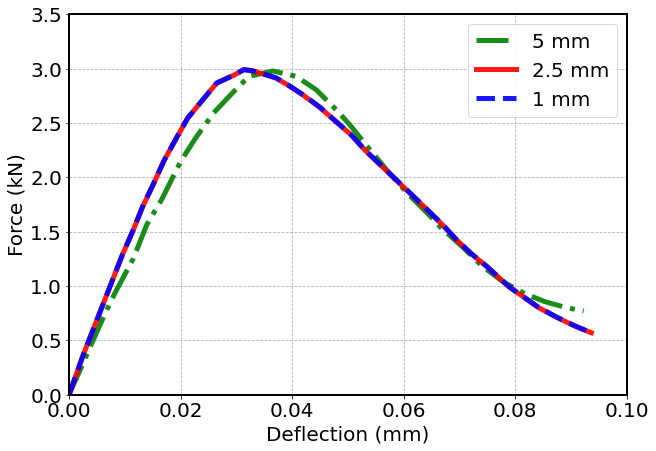

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel('Figure1.xlsx', sheet_name='Sheet1')
df.columns = ['Deflection-1mm', 'Force-1mm', 'NA', 'Deflection-2.5mm', 'Force-2.5mm', 'NA', 'Deflection-5mm', 'Force-5mm']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#fig.suptitle('Mesh Convergence', fontsize=24, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20
alpha = 0.9

ax.plot(df['Deflection-5mm'], df['Force-5mm']/1000, 'g-.', alpha=alpha, label='5 mm')
ax.plot(df['Deflection-2.5mm'], df['Force-2.5mm']/1000, 'r-', alpha=alpha, label='2.5 mm')
ax.plot(df['Deflection-1mm'], df['Force-1mm']/1000, 'b--', alpha=alpha, label='1 mm')

ax.set_xlim([0, 0.1])
ax.set_ylim([0, 3.5])
ax.set_xlabel('Deflection (mm)')
ax.set_ylabel('Force (kN)')
ax.legend(['5 mm', '2.5 mm', '1 mm'], prop={'size': 20})
ax.grid(True, linestyle='--')

for axs in ['top','bottom','left','right']:
    ax.spines[axs].set_linewidth(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       0 non-null      float64
 3   3       27 non-null     float64
 4   4       27 non-null     float64
dtypes: float64(5)
memory usage: 39.2 KB


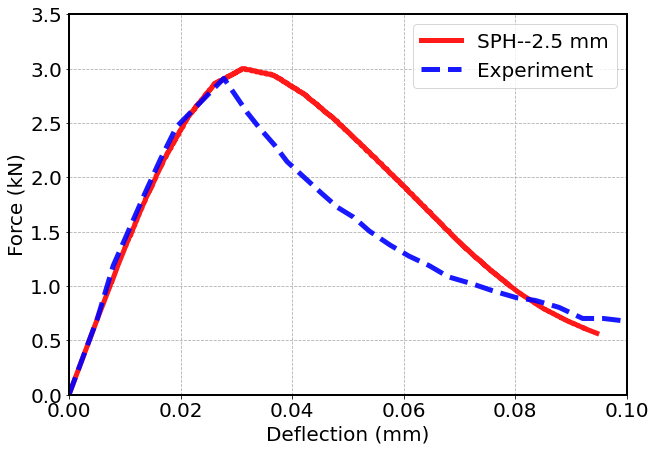

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel('Figure2.xlsx', sheet_name='Sheet1', header=None)
df.info()
df.columns = ['Deflection-2.5mm', 'Force-2.5mm', 'NA', 'Deflection-exp', 'Force-exp']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#fig.suptitle('Mesh Convergence', fontsize=24, fontweight='bold')
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20
alpha = 0.9

ax.plot(df['Deflection-2.5mm'], df['Force-2.5mm']/1000, 'r-', alpha=alpha, label='2.5 mm')
ax.plot(df['Deflection-exp'], df['Force-exp']/1000, 'b--', alpha=alpha, label='Exp')

ax.set_xlim([0, 0.1])
ax.set_ylim([0, 3.5])
ax.set_xlabel('Deflection (mm)')
ax.set_ylabel('Force (kN)')
ax.legend(['SPH--2.5 mm', 'Experiment'], prop={'size': 20})
ax.grid(True, linestyle='--')

for axs in ['top','bottom','left','right']:
    ax.spines[axs].set_linewidth(2)